In [2]:
from time import time

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from dataset import SyntheticSlateBanditDataset
from policy import gen_eps_greedy
from estimator import (
    SlateStandardInversePropensityScore as SIPS, 
    SlateIndependentInversePropensityScore as IIPS,
    SlateRewardInteractionInversePropensityScore as RIPS
)

In [3]:
def _gen_input_data(
    data: dict,
    len_list: int,
    alpha: np.ndarray,
    evaluation_policy_pscore,
    evaluation_policy_pscore_item_position,
    evaluation_policy_pscore_cascade
) -> dict:
    input_data = {
        "SIPS": (
            data["reward"], 
            alpha, 
            np.tile(data["pscore"][:,np.newaxis], reps=len_list), 
            np.tile(evaluation_policy_pscore[:,np.newaxis], reps=len_list)
        ),
        "IIPS": (
            data["reward"], 
            alpha,
            data["pscore_item_position"],
            evaluation_policy_pscore_item_position
        ),
        "RIPS": (
            data["reward"], 
            alpha,
            data["pscore_item_position"],
            evaluation_policy_pscore_cascade
        )
    }
    return input_data

In [7]:
# setting 1

# 変数
val_sizes=[200, 300, 500, 700, 900]

# 定数
reward_structure="cascade"
test_size=1000
n_sim=3
dim_context=5
n_actions=3
len_list=3
alpha = np.ones(len_list)
eps=0.5

In [8]:
# experiment-1 varying data size

dataset = SyntheticSlateBanditDataset(
    n_unique_action=n_actions,
    len_list=len_list,
    dim_context=dim_context,
    reward_structure=reward_structure
)
# calculate ground truth policy value
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
policy_value = dataset.calc_ground_truth_policy_value(
    expected_reward=test_data['expected_reward'],
    evaluation_policy=gen_eps_greedy(expected_reward=test_data['expected_reward'], eps=eps),
    alpha=alpha
)

result_df_list = []
for val_size in val_sizes:
    
    result_list = []
    for seed in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        dataset = SyntheticSlateBanditDataset(
            n_unique_action=n_actions,
            len_list=len_list,
            dim_context=dim_context,
            random_state=seed,
        )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # ranking policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data['expected_reward'], eps=eps)
        evaluation_policy_pscore = evaluation_policy[np.arange(val_size), val_data["slate_id"]]
        
        # marginal policy at position
        _, evaluation_policy_pscore_item_position = dataset.compute_marginal_probability_at_position(
            ranking_pi=evaluation_policy,
            slate_actions=val_data["action"]
        )
        
        # marginal policy cascade
        _, evaluation_policy_pscore_cascade = dataset.compute_marginal_probability_cascade(
            ranking_pi=evaluation_policy,
            slate_actions=val_data["action"]
        )
        
        
        input_data = _gen_input_data(
            data=val_data,
            len_list=len_list,
            alpha=alpha,
            evaluation_policy_pscore=evaluation_policy_pscore,
            evaluation_policy_pscore_item_position=evaluation_policy_pscore_item_position,
            evaluation_policy_pscore_cascade=evaluation_policy_pscore_cascade
        )
        
        estimators = [SIPS(estimator_name="SIPS"), IIPS(estimator_name="IIPS"), RIPS(estimator_name="RIPS")]
        estimated_policy_values = dict()
        for estimator in estimators:
            estimated_policy_value = estimator.estimate_policy_value(*input_data[estimator.estimator_name])
            estimated_policy_values[estimator.estimator_name] = estimated_policy_value
        
        result_list.append(estimated_policy_values)
        
    result_df = (
        DataFrame(DataFrame(result_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "estimator", 0: "value"})
    )
    result_df["n_val_data"] = val_size
    result_df["se"] = (result_df["value"] - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    
    expected_values = result_df.groupby('estimator').agg({"value": "mean"})["value"].to_dict()
    for estimator_name, expected_value in expected_values.items():

        row = result_df["estimator"] == estimator_name

        result_df.loc[row, "bias"] = (policy_value - expected_value) ** 2

        estimated_values = result_df[row]["value"].values
        result_df.loc[row, "variance"] = estimated_values.var()
    
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=200...: 100% 3/3 [00:10<00:00,  3.58s/it]
val_size=300...: 100% 3/3 [00:12<00:00,  4.23s/it]
val_size=500...: 100% 3/3 [00:20<00:00,  6.70s/it]
val_size=700...: 100% 3/3 [00:26<00:00,  8.81s/it]
val_size=900...: 100% 3/3 [00:34<00:00, 11.41s/it]


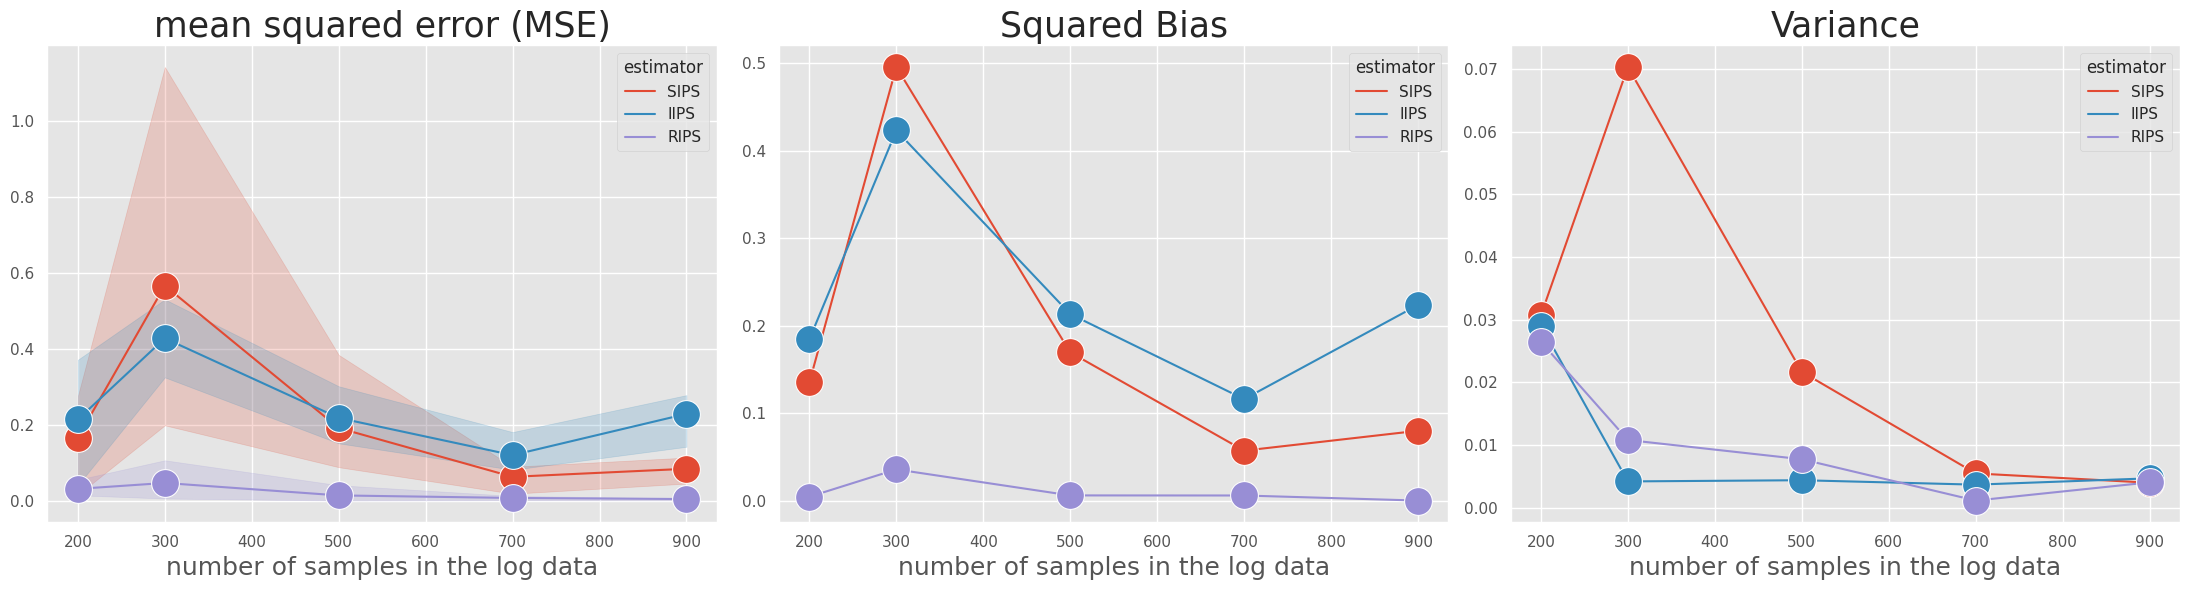

In [9]:
plt.style.use("ggplot")
fig, axes = plt.subplots(1,3, figsize=(22,6))

y=["se", "bias", "variance"]
ci=[95, None, None]
title=["mean squared error (MSE)", "Squared Bias", "Variance"]

for ax_, y_, ci_, title_ in zip(axes, y, ci, title):
    
    sns.lineplot(
        data=result_df, 
        x="n_val_data", 
        y=y_, 
        hue="estimator", 
        marker="o",
        markersize=20,
        ci=ci_, 
        ax=ax_
    )

    # title
    ax_.set_title(title_, fontsize=25)
    # yaxis
    ax_.set_ylabel('')
    # xaxis
    ax_.set_xlabel("number of samples in the log data", fontsize=18)


plt.tight_layout()
plt.show()

In [109]:
len_list = 3
interaction_range=1

marginal_pi_i = [[] for _ in range(len(all_slate))]
for i, slate in enumerate(all_slate):
    for pos_ in range(len_list):
        
        left_, right_ = max(pos_ - interaction_range, 0), min(pos_ + interaction_range + 1, len_list)
        
        ranking_indicator = np.all(all_slate[:, left_:right_] == slate[left_:right_], axis=1)
        marginal_pscore = ranking_pi_i[ranking_indicator].sum()
        marginal_pi_i[i].append(marginal_pscore)

In [112]:
marginal_pi_i = np.array(marginal_pi_i)